Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

Load data

In [3]:
data_path = "dataset/creditcard.csv"
df = pd.read_csv(data_path)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [6]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 31)
Anomaly: (492, 31)


Split the data into training, validation and test sets in 60/20/20

Use train_test_split to first obtain the train and test sets in 80/20 and then use the 80 training set to further split into validation set (0.25*0.8=0.2)

In [7]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

In [8]:
normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

Create final training, test and validation by concatenating the splits

In [9]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [10]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

Drop Class column

In [11]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [12]:
#Data shapes
print("Training sets:\nx_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} y_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} y_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 30) y_train: (85588,)

Testing sets:
x_test: (28531, 30) y_test: (28531,)

Validation sets:
x_validate: (28531, 30) y_validate: (28531,)


Data Normalization

In [13]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [14]:
#Logistic Regression
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(x_train, y_train)

In [15]:
#Model Evaluation
eval_acc = sk_model.score(x_test, y_test)

In [16]:
preds = sk_model.predict(x_test)
auc_score = roc_auc_score(y_test, preds)

In [17]:
print(f"Auc Score: {auc_score:.3%}")
print(f"Eval Accuracy: {eval_acc:.3%}")

Auc Score: 84.331%
Eval Accuracy: 99.867%


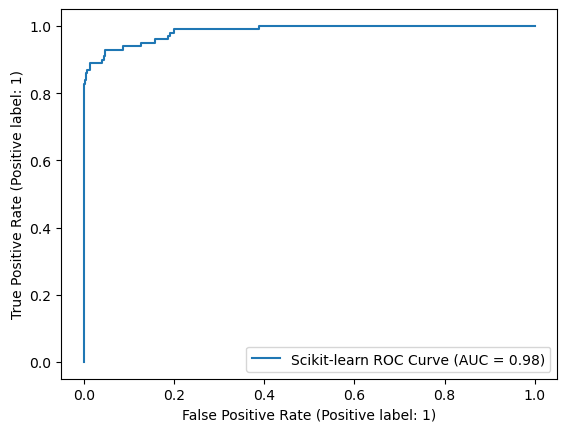

In [18]:
roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')

Text(0.5, 23.52222222222222, 'Predicted')

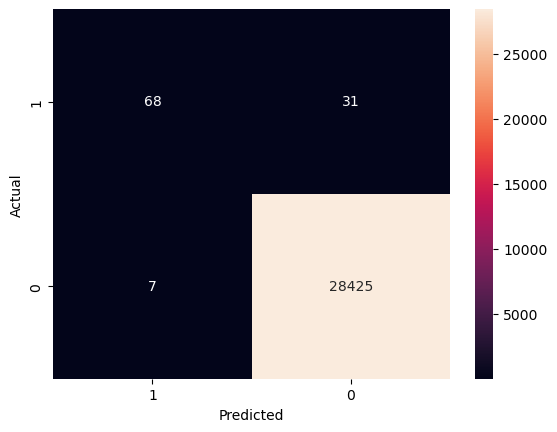

In [19]:
conf_matrix = confusion_matrix(y_test, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [20]:
anomaly_weights = [1, 5, 10, 15]

In [21]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

Validation Script

In [22]:
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        weight = anomaly_weights[f]
        
        class_weights= {
            0:1,
            1: weight}        
        
        sk_model = LogisticRegression(random_state=None,
                                      max_iter=400,
                                      solver='newton-cg',
                                      class_weight=class_weights).fit(x_validate[train], y_validate[train])
        
        for h in range(40): print('-', end="")
        print(f"\nfold {fold}\nAnomaly Weight: {weight}")
        
        eval_acc = sk_model.score(x_validate[test], y_validate[test])
        preds = sk_model.predict(x_validate[test])
        
        try:
            auc_score = roc_auc_score(y_validate[test], preds)
        except:
            auc_score = -1
        
        print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
        
        accuracies.append(eval_acc)
        auc_scores.append(auc_score)
        
        log = [sk_model, x_validate[test], y_validate[test], preds]
        logs.append(log)
        
        fold = fold + 1
        
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985629653623302
AUC:  0.8391790849957024
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomal

In [23]:
#Anomaly weight 10 gives the best results, select from logs[index_11]
sk_model, x_val, y_val, preds = logs[11]

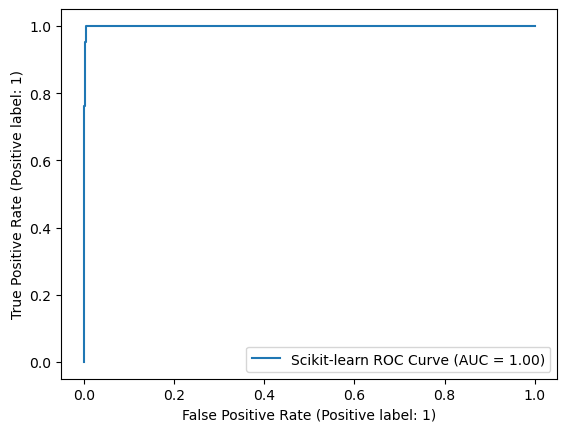

In [24]:
#Plot the ROC curve 
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name='Scikit-learn ROC Curve')

Text(0.5, 23.52222222222222, 'Predicted')

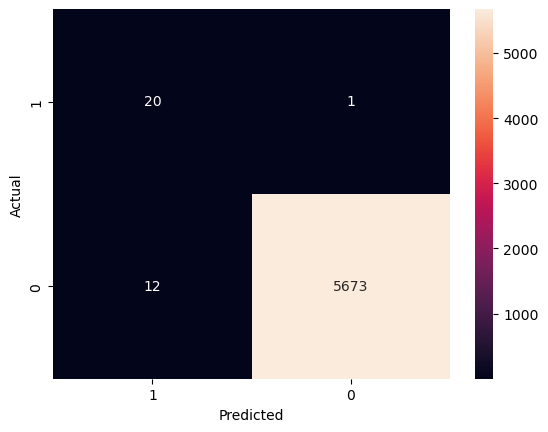

In [25]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_val, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')